In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import datasets 
from tensorflow.keras.utils import to_categorical;

def Conv2D(filters, kernel_size, padding='same', activation='relu'):
    return layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)

In [2]:
class DATA():
    def __init__(self):
        num_classes = 10

        (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
        img_rows, img_cols = x_train.shape[1:]

        if backend.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        y_train = to_categorical(y_train, num_classes)
        y_test = to_categorical(y_test, num_classes)
        
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test

In [3]:
class AE(models.Model):
    def __init__(self, org_shape=(1, 28, 28)):
        # Input
        with tf.device('/gpu:0'):
            original = layers.Input(shape=org_shape)

            # encoding-1
            x = Conv2D(4, (3, 3))(original)
            x = layers.MaxPooling2D((2, 2), padding='same')(x)

            # encoding-2
            x = Conv2D(8, (3, 3))(x)
            x = layers.MaxPooling2D((2, 2), padding='same')(x)

            # encoding-3: encoding output: 7x7 pixels
            z = Conv2D(1, (7, 7))(x)

            # decoding-1
            y = Conv2D(16, (3, 3))(z)
            y = layers.UpSampling2D((2, 2))(y)

            # decoding-2
            y = Conv2D(8, (3, 3))(y)
            y = layers.UpSampling2D((2, 2))(y)

            # decoding-3
            y = Conv2D(4, (3, 3))(y)

            # decoding & Output
            decoded = Conv2D(1, (3, 3), activation='sigmoid')(y)

            super().__init__(original, decoded)
            self.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
            

In [4]:
from keraspp.skeras import plot_acc, plot_loss
import matplotlib.pyplot as plt
from tensorflow.keras import backend

def show_AE(autoencoder, data):
    x_test = data.x_test
    
    decoded_imgs = autoencoder.predict(x_test)
    print(decoded_imgs.shape, data.x_test.shape)

    if backend.image_data_format() == 'channels_first':
        N,n_ch,n_i, n_j = x_test.shape
    else:
        N, n_i,n_j,n_ch = x_test.shape
        
    x_test = x_test.reshape(N,n_i,n_j)
    decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0],n_i,n_j)
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):

        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i])
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        
    plt.show()

In [5]:
epochs = 20
batch_size =128
data = DATA()
autoencoder = AE(data.input_shape)
history = autoencoder.fit(data.x_train, data.x_train, epochs=epochs,
                          batch_size=batch_size, shuffle=True, validation_split=0.2)


Epoch 1/20
375/375 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.6933 - val_loss: 0.6922 - val_accuracy: 0.7683
Epoch 2/20
375/375 [==============================] - 1s 3ms/step - loss: 0.6915 - accuracy: 0.7886 - val_loss: 0.6905 - val_accuracy: 0.8015
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 0.6894 - accuracy: 0.8056 - val_loss: 0.6882 - val_accuracy: 0.8086
Epoch 4/20
375/375 [==============================] - 1s 3ms/step - loss: 0.6868 - accuracy: 0.8085 - val_loss: 0.6853 - val_accuracy: 0.8092
Epoch 5/20
375/375 [==============================] - 1s 3ms/step - loss: 0.6836 - accuracy: 0.8087 - val_loss: 0.6817 - val_accuracy: 0.8093
Epoch 6/20
375/375 [==============================] - 1s 3ms/step - loss: 0.6795 - accuracy: 0.8087 - val_loss: 0.6771 - val_accuracy: 0.8093
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.6742 - accuracy: 0.8087 - val_loss: 0.6708 - val_accuracy: 0.8093
Epoch 

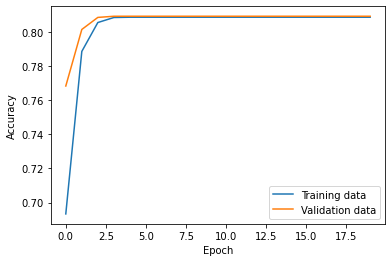

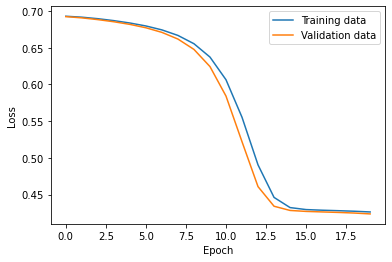

(10000, 28, 28, 1) (10000, 28, 28, 1)


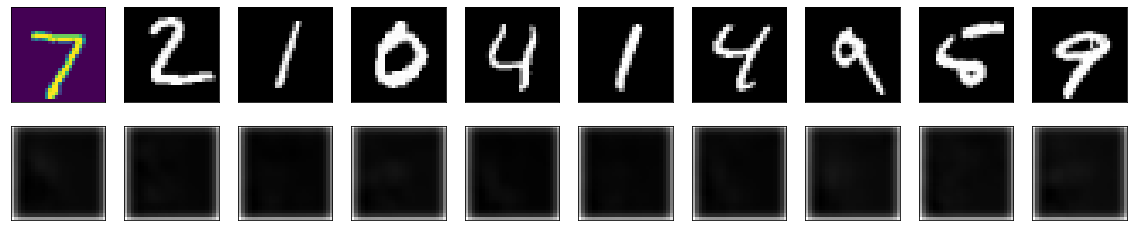

In [8]:
plot_acc(history)
plt.show()
plot_loss(history)
plt.show()

show_AE(autoencoder, data)
plt.show()